In [40]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import TypedDict, Annotated
import os
from dotenv import load_dotenv


In [42]:
load_dotenv()
api_key = os.getenv("gemini")


In [43]:
model = ChatGoogleGenerativeAI(temperature=0, model="gemma-3-4b-it", api_key= api_key)

In [44]:
from pydantic import BaseModel, Field

In [45]:
class EvaluationSchema(BaseModel):
    feedback: str = Field(description="Feedback on the essay")
    score: int = Field(description="Score for the essay out of 10", ge=0, le=10 )
    

In [46]:
essay = """ Essay on Indian Economy

The Indian economy is one of the fastest-growing and most diverse economies in the world. It reflects a blend of traditional agriculture, modern industries, and a strong service sector. Over the years, India has transformed from being an agrarian economy to an emerging global economic power.

Historical Background

India’s economy has evolved significantly since independence in 1947. Initially, the focus was on self-reliance, with large-scale public sector enterprises and five-year plans guiding development. However, the growth remained slow during the first few decades. The economic reforms of 1991 marked a turning point, when liberalization, privatization, and globalization (LPG) policies opened India’s economy to the world.

Sectors of the Economy

The Indian economy is broadly divided into three sectors:

Agriculture: Agriculture has traditionally been the backbone of India’s economy, employing a large portion of the population. Although its contribution to GDP has declined, it remains vital for food security and rural livelihoods.

Industry: The industrial sector includes manufacturing, mining, and construction. It plays a major role in infrastructure development and job creation. The “Make in India” initiative has further encouraged industrial growth.

Services: The service sector is the largest contributor to India’s GDP. IT, telecommunications, finance, education, healthcare, and tourism are major components. India is globally recognized for its IT and software services, with cities like Bengaluru and Hyderabad serving as technology hubs.

Strengths of the Indian Economy

Young Population: With a large youth workforce, India has the potential to become a global economic leader.

Diverse Resources: Rich natural resources, fertile land, and a wide range of industries contribute to economic stability.

Growing Middle Class: Rising incomes and urbanization fuel domestic consumption and demand.

Challenges

Despite progress, the Indian economy faces several challenges:

Unemployment and Underemployment: Many youth struggle to find suitable jobs.

Income Inequality: The gap between the rich and poor continues to widen.

Agricultural Distress: Farmers often face issues like low income, climate change, and lack of infrastructure.

Corruption and Red Tape: Bureaucratic hurdles can slow down development and discourage investment.

Future Prospects

India’s economy has immense potential for growth. With digitalization, renewable energy, and advancements in technology, the future looks promising. Government initiatives like Digital India, Startup India, and Atmanirbhar Bharat aim to strengthen self-reliance and innovation. If challenges are addressed effectively, India can achieve sustainable and inclusive growth in the coming decades.

Conclusion

The Indian economy stands at a crucial juncture, balancing its rich traditions with modern aspirations. With its vast human resources, technological advancements, and reform-oriented policies, India is poised to become a global economic powerhouse. The journey ahead will require inclusive development, where the benefits of growth reach every section of society."""

In [47]:
prompt = f"""Evaluate the following essay on the Indian economy and provide feedback and a score out of 10.{essay}"""

In [48]:
model.invoke(prompt).content

'Okay, here’s an evaluation of the essay on the Indian Economy, followed by a score and detailed feedback:\n\n**Overall Score: 7.5/10**\n\n**Strengths:**\n\n* **Clear Structure:** The essay follows a logical structure – historical background, sector breakdown, strengths, challenges, future prospects, and conclusion. This makes it easy to follow and understand.\n* **Good Overview:** It provides a decent, accessible overview of the Indian economy, hitting on key aspects like the shift from agriculture, the impact of liberalization, and the importance of the service sector.\n* **Relevant Points:** The identified strengths (young population, diverse resources, growing middle class) and challenges (unemployment, inequality, agricultural distress) are all accurate and significant issues facing India.\n* **Mention of Key Initiatives:**  Including “Make in India,” “Digital India,” “Startup India,” and “Atmanirbhar Bharat” demonstrates awareness of current government policies.\n* **Accessible L

In [50]:
import operator

In [80]:
class UPSCState(TypedDict):
    essay: Annotated[list[str], operator.getitem]
    launguage_feedback: str
    analysis_feedback : str
    clarity_feedback : str
    overall_feedback : str
    #individual_scores: Annotated[list[int], operator.add]
    #avg_score: float
    


In [65]:
def eavluate_launguage(state: UPSCState) -> UPSCState:
    prompt = f"""Evaluate the launguage quality following essay provide feedback and a score out of 10.{state['essay']}"""
    response = model.invoke(prompt).content
    state['launguage_feedback'] = response
    #state['individual_scores'].append(response.score)
    return state

In [70]:
def eavluate_analysis(state: UPSCState) -> UPSCState:
    prompt = f"""Evaluate the depth of the analysis following essay and provide feedback and a score out of 10.{state['essay']}"""
    response = model.invoke(prompt).content
    state['analysis_feedback'] = response
    #state['individual_scores'].append(response.score)
    return state

In [71]:
def eavluate_clarity(state: UPSCState) -> UPSCState:
    prompt = f"""Evaluate the clarity of thought the following essay and provide feedback and a score out of 10.{state['essay']}"""
    response = model.invoke(prompt).content
    state['clarity_feedback'] = response
    #state['individual_scores'].append(response.score)
    return state

In [72]:
def eavluate_overall(state: UPSCState) -> UPSCState:
    prompt = f"""Based on the following feedbacks provided, create a summrized feedback \n launguage feedback: {state['launguage_feedback']}\n analysis feedback: {state['analysis_feedback']}\n clarity feedback: {state['clarity_feedback']}"""
    response = model.invoke(prompt).content
    state['overall_feedback'] = response
    #state['individual_scores'].append(response.score)
    #state['avg_score'] = sum(state['individual_scores']) / len(state['individual_scores'])
    return state

In [73]:
graph = StateGraph(UPSCState)

graph.add_node('eavluate_launguage', eavluate_launguage)
graph.add_node('eavluate_analysis', eavluate_analysis)
graph.add_node('eavluate_clarity', eavluate_clarity)    
graph.add_node('eavluate_overall', eavluate_overall)

In [74]:
graph.add_edge(START, 'eavluate_launguage')
graph.add_edge(START, 'eavluate_analysis')   
graph.add_edge(START, 'eavluate_clarity')

graph.add_edge('eavluate_launguage', 'eavluate_overall')
graph.add_edge('eavluate_analysis', 'eavluate_overall')
graph.add_edge('eavluate_clarity', 'eavluate_overall')

graph.add_edge('eavluate_overall', END)

workflow = graph.compile()

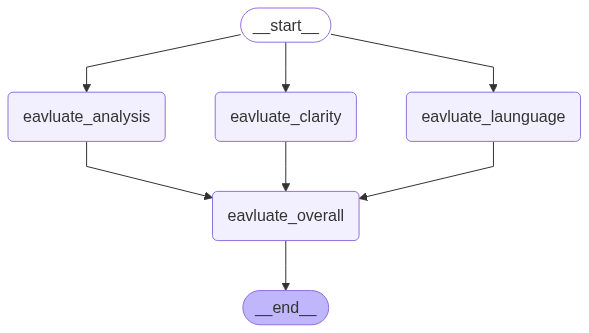

In [75]:
workflow

In [ ]:
intial_state = {'essay': essay}

workflow.invoke(intial_state)